In [1]:
import numpy as np 
import torch 
from tqdm import tqdm 
import pickle 
import pandas as pd
from typing import List, Dict, Any, Tuple, Union, Optional, Callable
import requests 
import time
from collections import defaultdict 
import os 

import datasets
from datasets import load_dataset
from dataclasses import dataclass
from transformers import AutoTokenizer, AutoModelForCausalLM
import sys

from white_box.model_wrapper import ModelWrapper
from white_box.utils import gen_pile_data 
from white_box.dataset import clean_data 
from white_box.chat_model_utils import load_model_and_tokenizer, get_template, MODEL_CONFIGS

from white_box.dataset import PromptDist, ActDataset, create_prompt_dist_from_metadata_path, ProbeDataset
from white_box.probes import LRProbe
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from datasets import load_from_disk, DatasetDict
from sklearn.metrics import accuracy_score, roc_auc_score
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as sklearn_auc

%load_ext autoreload
%autoreload 2

In [2]:
model_name = 'llama2_7b'
data_path = f"data/{model_name}"

In [3]:
# model_config = MODEL_CONFIGS[model_name]
# model, tokenizer = load_model_and_tokenizer(**model_config)
# template = get_template(model_name, chat_template=model_config.get('chat_template', None))['prompt']

# mw = ModelWrapper(model, tokenizer, template = template)

### plotting helper

In [4]:
def plot_probe_on_test_dataset(probes, test_dataset, title='test'): 
    
    metrics = defaultdict(list)

    for layer in range(32):
        pred_probas = probes[layer].predict_proba(test_dataset.act_dataset.X[:, layer])
        probas_mean = pred_probas.mean(dim=-1).detach().cpu().numpy()
        labels = test_dataset.act_dataset.y.detach().cpu().numpy()

        metrics['acc'].append(accuracy_score(labels, probas_mean > 0.5))
        metrics['auc'].append(roc_auc_score(labels, probas_mean))
        metrics['TPR'].append(((probas_mean > 0.5) & (labels == 1)).sum() / (labels == 1).sum())
        metrics['TNR'].append(((probas_mean < 0.5) & (labels == 0)).sum() / (labels == 0).sum())
        metrics['FPR'].append(((probas_mean > 0.5) & (labels == 0)).sum() / (labels == 0).sum())
        metrics['FNR'].append(((probas_mean < 0.5) & (labels == 1)).sum() / (labels == 1).sum())
    
    fig = go.Figure()
    x = list(range(32))
    fig.add_trace(go.Scatter(x=x, y=metrics['acc'], mode='lines', name='Accuracy'))
    fig.add_trace(go.Scatter(x=x, y=metrics['auc'], mode='lines', name='AUC'))
    fig.add_trace(go.Scatter(x=x, y=metrics['TPR'], mode='lines', name='TPR'))
    fig.add_trace(go.Scatter(x=x, y=metrics['TNR'], mode='lines', name='TNR'))
    fig.add_trace(go.Scatter(x=x, y=metrics['FPR'], mode='lines', name='FPR'))
    fig.add_trace(go.Scatter(x=x, y=metrics['FNR'], mode='lines', name='FNR'))
    fig.update_layout(
        title=f"Test on {title} dataset", 
        xaxis_title="Layers",
        yaxis_title="Value",
    )
    fig.show()
    
def results_given_probas(probas, labels): 
    print(f"Accuracy: {accuracy_score(labels, probas > 0.5)}")
    print(f"AUC: {roc_auc_score(labels, probas)}")
    print(f"TPR: {((probas > 0.5) & (labels == 1)).sum() / (labels == 1).sum()}")
    print(f"TNR: {((probas < 0.5) & (labels == 0)).sum() / (labels == 0).sum()}")
    print(f"FPR: {((probas > 0.5) & (labels == 0)).sum() / (labels == 0).sum()}")
    print(f"FNR: {((probas < 0.5) & (labels == 1)).sum() / (labels == 1).sum()}")
    
def plot_roc_curves(preds, labels): 
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = sklearn_auc(fpr, tpr)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title(f'ROC Curve Layer 24')
    ax[0].legend()

    # plot 0 to 5% FPR range
    ax[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_xlim([0, 0.05])
    ax[1].set_ylim([0, 1])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title(f'ROC Curve Layer 24')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

## probing harmful vs harmless input

In [58]:
from white_box.jb_experiments import plot_acc_auc
file_spec = "jb_"
harmful = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1)")
harmless =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0)")
print(len(harmless.idxs), len(harmful.idxs))
dataset = ActDataset([harmful], [harmless])
dataset.instantiate()
jb_probe_dataset = ProbeDataset(dataset)

630 430


In [59]:
from white_box.jb_experiments import plot_acc_auc
file_spec = "harmbench_alpaca_"
harmful = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1)")
harmless =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0)")
print(len(harmless.idxs), len(harmful.idxs))
dataset = ActDataset([harmful], [harmless])
dataset.instantiate()
hb_alpaca_probe_dataset = ProbeDataset(dataset)

1200 1200


In [60]:
from white_box.jb_experiments import plot_acc_auc
file_spec = "harmbench_alpaca_test_"
harmful = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1)")
harmless =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0)")
print(len(harmless.idxs), len(harmful.idxs))
dataset = ActDataset([harmful], [harmless])
dataset.instantiate()
hb_alpaca_test_probe_dataset = ProbeDataset(dataset)

295 295


In [61]:
from white_box.jb_experiments import plot_acc_auc
file_spec = "generated_"
harmful = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1)")
harmless =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0)")
print(len(harmless.idxs), len(harmful.idxs))
dataset = ActDataset([harmful], [harmless])
dataset.instantiate()
generated_probe_dataset = ProbeDataset(dataset)

1200 1200


In [62]:
file_spec = 'generated_test_'
harmful = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1)")
harmless =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0)")
print(len(harmless.idxs), len(harmful.idxs))
dataset = ActDataset([harmful], [harmless])
dataset.instantiate()
generated_test_probe_dataset = ProbeDataset(dataset)


299 295


In [63]:
file_spec = "jb_"
jb_metadata = pd.read_csv(f"{data_path}/{file_spec}metadata.csv", sep = "t")
jbs =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1) & (metadata['jb_name'] != 'DirectRequest')")
failed_jbs = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0) & (metadata['jb_name'] != 'DirectRequest') & (metadata['jb_name'] != 'harmless')")
print(len(jbs.idxs), len(failed_jbs.idxs))
dataset = ActDataset([jbs], [failed_jbs])
dataset.instantiate()
jb_labeled_by_success_probe_dataset = ProbeDataset(dataset)

427 430


In [64]:
# from sklearn.decomposition import PCA 
# from sklearn.preprocessing import StandardScaler
# tok_idx = 0
# layer = 16

# X = probe_dataset.act_dataset.X[:, layer, tok_idx]
# pca = PCA(n_components=2)
# pca.fit(X.numpy())

# normalize = False

# if normalize:
#     scaler = StandardScaler()
#     X_normalized = scaler.fit_transform(X)
#     pca_result = pca.fit_transform(X_normalized)
# else:
#     pca_result = pca.fit_transform(X)

# pc_x = 0
# pc_y = 1
# pca_df = pd.DataFrame.from_dict({"x" : pca_result[:, pc_x], 
#                         "y" : pca_result[:, pc_y], 
#                         "label": probe_dataset.act_dataset.y,
#                         "prompt": generated_metadata['prompt'].values, 
#                         })
# fig = px.scatter(pca_df, x="x", y="y", hover_data = ["prompt"],
#                  color="label", 
#                  )
# fig.update_layout(
#     title=f'PCA of Layer {layer} Activations, TOKEN_IDX {tok_idx}',
#     xaxis_title=f'PC{pc_x}',
#     yaxis_title=f'PC{pc_y}',
#     showlegend=True
# )

# fig.show()

In [65]:
accs, aucs, probes = [], [], []
for layer in tqdm(range(32)):
    acc, auc, probe = generated_probe_dataset.train_sk_probe(layer, tok_idxs = list(range(5)), test_size = 0, C = 1e-2, 
                                                  max_iter = 2000,
                                                   random_state = None, use_train_test_split=False)

    # acc, auc, probe = probe_dataset.train_mm_probe(layer, tok_idxs=list(range(5)), test_size=None, device='cpu')

    accs.append(acc)
    aucs.append(auc)
    probes.append(probe)

100%|██████████| 32/32 [01:28<00:00,  2.77s/it]


In [66]:
plot_acc_auc(accs, aucs, title = "Generated Train, probes trained on last 5 token positions")

In [67]:
plot_probe_on_test_dataset(probes, hb_alpaca_test_probe_dataset, title='HB-alpaca')

In [68]:
plot_probe_on_test_dataset(probes, generated_test_probe_dataset, title='Generated Test')

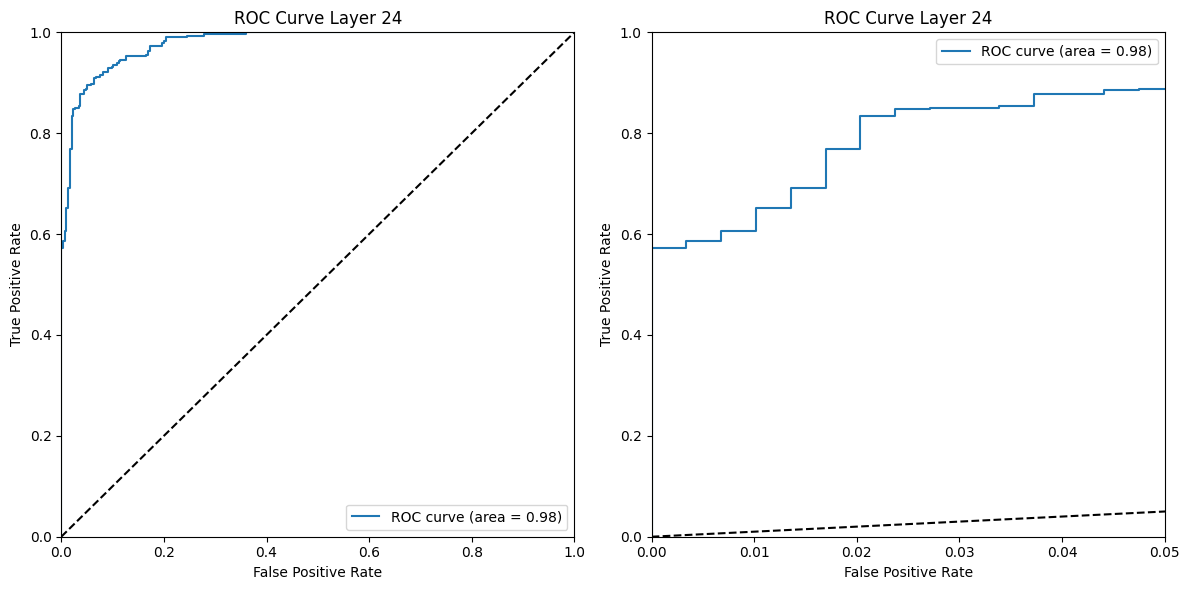

In [71]:
# get roc for layer 24 probe

pred_probas = probes[24].predict_proba(hb_alpaca_test_probe_dataset.act_dataset.X[:, 24])
probas_mean = pred_probas.mean(dim=-1).detach().cpu().numpy()
labels = hb_alpaca_test_probe_dataset.act_dataset.y.detach().cpu().numpy()

plot_roc_curves(probas_mean, labels)


## Test classifier

In [5]:
def get_batched_preds(prompts: List[str], model: torch.nn.Module, tokenizer: AutoTokenizer, device: str, batch_size: int = 8) -> np.ndarray:
    toks = [tokenizer.apply_chat_template([{"role": "user", "content": prompt}]) for prompt in prompts]
    max_len = max([len(t) for t in toks])
    for i in range(len(toks)):
        toks[i] = [tokenizer.pad_token_id] * (max_len - len(toks[i])) + toks[i]
    toks = torch.tensor(toks).to(device)
    preds = []
    for i in tqdm(range(0, len(toks), batch_size)): 
        output = model(toks[i:i+batch_size])
        preds.append(torch.stack([output.logits[:,-1, 9109], output.logits[:,-1, 25110]], dim=1).softmax(-1).cpu().detach().numpy()[:,1])
    return np.concatenate(preds)

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from peft import AutoPeftModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("meta-llama/LlamaGuard-7b", padding_side='left')
tokenizer.pad_token = tokenizer.eos_token
# model = AutoPeftModelForSequenceClassification.from_pretrained("../data/llama2_7b/llamaguard_generated__model_1", torch_dtype=torch.bfloat16, num_labels=2)
# model = model.merge_and_unload()
model = AutoModelForCausalLM.from_pretrained("data/llama2_7b/llamaguard_generated__model_2", torch_dtype=torch.bfloat16)
model.config.pad_token_id = model.config.eos_token_id

device = 'cuda'
_ = model.to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
path = 'data/llama2_7b'

generated_df = pd.read_csv(os.path.join(path, 'generated_test_metadata.csv'))
hb_alpaca_df = pd.read_csv(os.path.join(path, 'harmbench_alpaca_test_metadata.csv'))

In [8]:
preds = get_batched_preds(generated_df['prompt'].values, model, tokenizer, device, batch_size=8)
labels = generated_df['label'].values

results_given_probas(preds, labels)

100%|██████████| 75/75 [02:21<00:00,  1.89s/it]

Accuracy: 0.6026936026936027
AUC: 0.5974151125219658
TPR: 0.2
TNR: 1.0
FPR: 0.0
FNR: 0.8


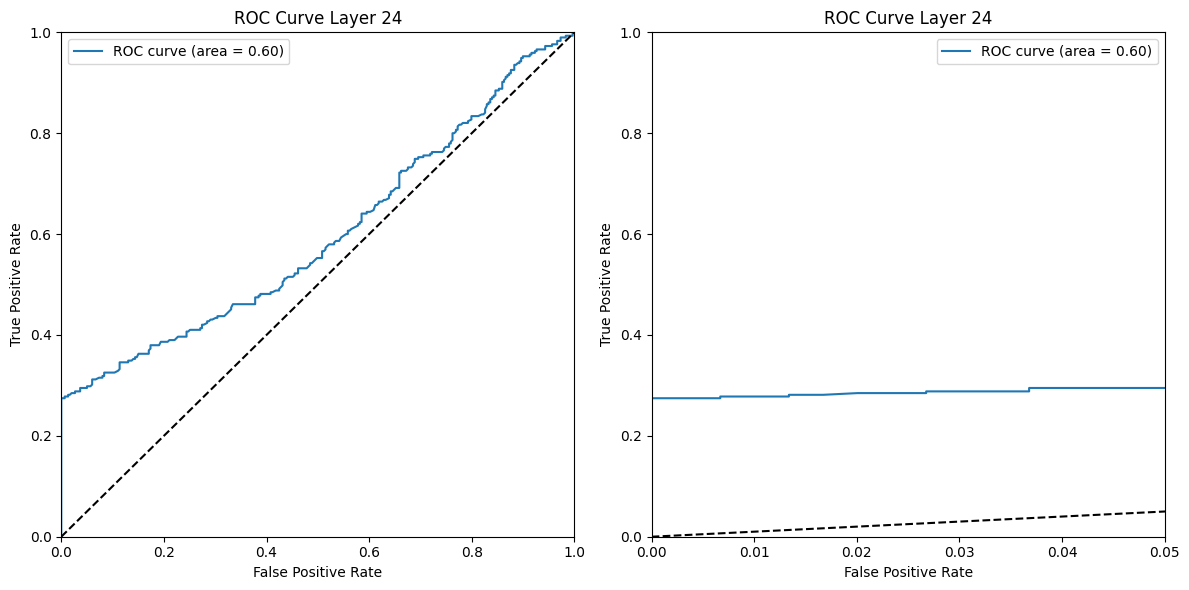

In [9]:
plot_roc_curves(preds, labels)

In [10]:
hb_alpaca_preds = get_batched_preds(hb_alpaca_df['prompt'].values, model, tokenizer, device, batch_size=8)
hb_alpaca_labels = hb_alpaca_df['label'].values

results_given_probas(hb_alpaca_preds, hb_alpaca_labels)

100%|██████████| 74/74 [01:33<00:00,  1.27s/it]

Accuracy: 0.576271186440678
AUC: 0.7097845446710715
TPR: 0.15254237288135594
TNR: 1.0
FPR: 0.0
FNR: 0.847457627118644


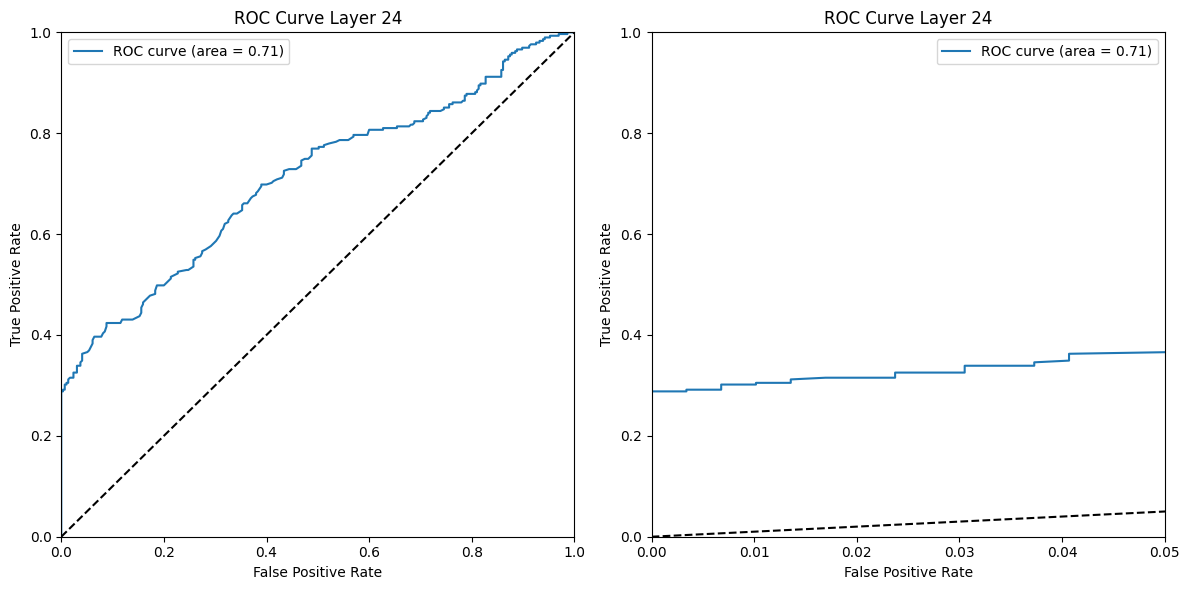

In [11]:
plot_roc_curves(hb_alpaca_preds, hb_alpaca_labels)

In [12]:
advbench_positives = pd.read_csv('data/harmful_behaviors_custom.csv')['goal'].tolist()
gpt_negatives = pd.read_csv('data/harmless_behaviors_custom.csv')['prompt'].tolist()

advbench_preds = get_batched_preds(advbench_positives, model, tokenizer, device)
gpt_preds = get_batched_preds(gpt_negatives, model, tokenizer, device)


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


(array([27.,  9.,  3.,  2.,  3.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00170072, 0.02049272, 0.03928472, 0.05807672, 0.07686871,
        0.09566071, 0.11445271, 0.13324471, 0.15203671, 0.1708287 ,
        0.1896207 , 0.20841269, 0.2272047 , 0.2459967 , 0.26478869,
        0.28358069, 0.30237269, 0.3211647 , 0.33995667, 0.35874867,
        0.37754068]),
 <BarContainer object of 20 artists>)

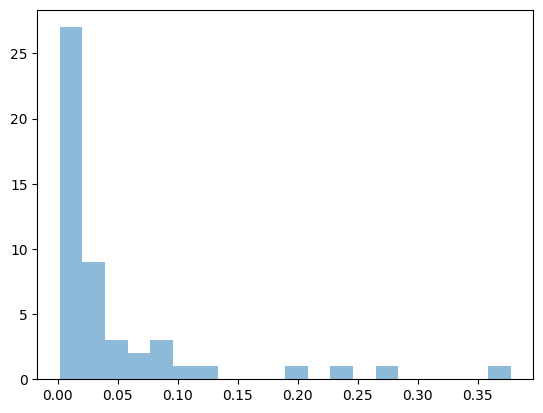

In [13]:
plt.hist(gpt_preds, bins=20, alpha=0.5, label='gpt')

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,
         0.,  0.,  1.,  3.,  2.,  3., 36.]),
 array([0.99029154, 0.99077517, 0.99125886, 0.99174249, 0.99222612,
        0.99270982, 0.99319345, 0.99367708, 0.99416077, 0.9946444 ,
        0.99512804, 0.99561173, 0.99609536, 0.99657905, 0.99706268,
        0.99754632, 0.99803001, 0.99851364, 0.99899727, 0.99948096,
        0.99996459]),
 <BarContainer object of 20 artists>)

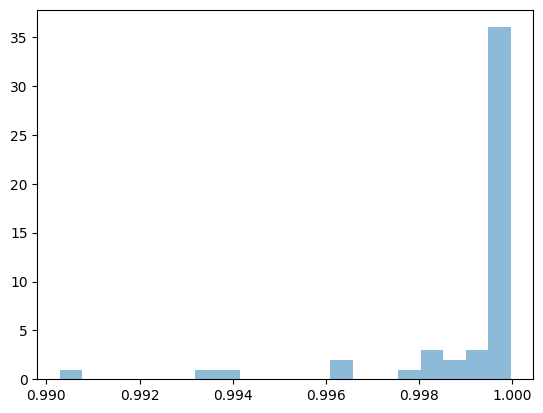

In [14]:
plt.hist(advbench_preds, bins=20, alpha=0.5, label='advbench')

## Test correlation of errors

In [ ]:
errors = (preds > 0.5) != labels
